## This section is necessary to import files and datasets

In [ ]:
# === Basic Libraries ===
import os
import re
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === System Utilities ===
from google.colab import drive
from IPython.display import display, clear_output
import kagglehub

# === Deep Learning ===
import torch
import torch.nn as nn
from tensorflow.keras.models import load_model, model_from_json, Sequential

# === Machine Learning ===
import joblib
from xgboost import XGBClassifier

# === Image Processing ===
import cv2

# === NLP ===
import nltk
from nltk.corpus import stopwords

# === OpenAI Integration ===
import openai


In [ ]:
!pip install --upgrade openai
clear_output()
print("✅ openai upgraded successfully.")

✅ openai upgraded successfully.


In [ ]:
# Import the files from Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [ ]:
# Model 1 Dataset
path = kagglehub.dataset_download("nasirayub2/human-vital-sign-dataset")
print("Path to dataset files:", path)

#Model 2 Dataset
path = kagglehub.dataset_download("uom190346a/sleep-health-and-lifestyle-dataset")
print("Path to dataset files:", path)

#Model 4 Dataset
path = kagglehub.dataset_download("taqiyyaghazi/emotion-speech-features-for-speech-recognition")
print("Path to dataset files:", path)

# Model 5 Dataset
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
print("Path to dataset files:", path)

100%|██████████| 14.0M/14.0M [00:00<00:00, 42.8MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/nasirayub2/human-vital-sign-dataset/versions/1


100%|██████████| 2.54k/2.54k [00:00<00:00, 2.63MB/s]

Extracting files...
Path to dataset files: /content/data/datasets/uom190346a/sleep-health-and-lifestyle-dataset/versions/2


100%|██████████| 20.4k/20.4k [00:00<00:00, 25.9MB/s]

Extracting files...
Path to dataset files: /content/data/datasets/taqiyyaghazi/emotion-speech-features-for-speech-recognition/versions/1


100%|██████████| 121M/121M [00:02<00:00, 50.7MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1


## Model 1 (Vital Signs Monitoring)

In [ ]:
# === Define the model architecture ===
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# === Load model, scaler, and encoder ===
timestamp = "20250327_032916"
base_path = "/content/drive/MyDrive/Hackathon Models/1. Wearable Sensor Data for Vital Signs Monitoring/"
model_path   = f"{base_path}model_vital_{timestamp}.pth"
scaler_path  = f"{base_path}scaler_vital_{timestamp}.pkl"
encoder_path = f"{base_path}encoder_vital_{timestamp}.pkl"

input_size = 9
model = DNN(input_size=input_size)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

scaler = joblib.load(scaler_path)
label_encoder = joblib.load(encoder_path)

# === Data Preparation Function ===
def prepare_input(df):
    df = df.copy()
    df = df.drop_duplicates()
    columns_to_drop = [
        'Timestamp', 'Patient ID', 'Gender',
        'Derived_HRV', 'Derived_Pulse_Pressure',
        'Derived_BMI', 'Derived_MAP'
    ]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    if 'Risk Category' in df.columns:
        y = df['Risk Category']
        X = df.drop(columns=['Risk Category'])
    else:
        y = None
        X = df
    return X, y

# === Load and preprocess dataset ===
df = pd.read_csv("/content/data/datasets/nasirayub2/human-vital-sign-dataset/versions/1/human_vital_signs_dataset_2024.csv")
X, y = prepare_input(df)

In [ ]:
# === Pick one random sample ===
random_index = np.random.choice(len(X))
sample = X.iloc[random_index:random_index+1]  # DataFrame format for table display

# === Scale and predict ===
sample_scaled = scaler.transform(sample)
sample_tensor = torch.tensor(sample_scaled, dtype=torch.float32)

with torch.no_grad():
    logit = model(sample_tensor)
    prob = torch.sigmoid(logit).item()
    pred = int(prob >= 0.5)
    decoded_pred = label_encoder.inverse_transform([pred])[0]

# === Display the result ===
print("🧪 Vital Sign Inputs:")
display(sample)

print(f"\n✅ Predicted Risk: **{decoded_pred}**")
vital_signs = decoded_pred

🧪 Vital Sign Inputs:


,Heart Rate,Respiratory Rate,Body Temperature,Oxygen Saturation,Systolic Blood Pressure,Diastolic Blood Pressure,Age,Weight (kg),Height (m)
130217,66,18,36.841039,95.164139,116,75,86,94.808637,1.593459



✅ Predicted Risk: **High Risk**


## Model 2 (Sleep Pattern and Fatigue)

In [ ]:
# === 1. Load saved model and encoder ===
model_path = "/content/drive/MyDrive/Hackathon Models/2. Sleep Pattern and Fatigue Monitoring/xgb_sleep_model.pkl"
encoder_path = "/content/drive/MyDrive/Hackathon Models/2. Sleep Pattern and Fatigue Monitoring/label_encoder.pkl"

model = joblib.load(model_path)
label_encoder = joblib.load(encoder_path)

# === 2. Load and preprocess the raw data ===
df = pd.read_csv("/content/data/datasets/uom190346a/sleep-health-and-lifestyle-dataset/versions/2/Sleep_health_and_lifestyle_dataset.csv")
df = df.drop_duplicates()
df = df.drop(columns=['Person ID'], errors='ignore')
df["Sleep Disorder"] = df["Sleep Disorder"].fillna("None")

# === 3. Encode categorical columns same as training ===
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure']
for col in categorical_cols:
    df[col] = df[col].astype('category').cat.codes

# === 4. Prepare features and labels ===
X = df.drop(columns=["Sleep Disorder"])
y = df["Sleep Disorder"]



In [ ]:
# === 5. Pick ONE random sample ===
sample_idx = np.random.choice(len(X), size=1, replace=False)[0]
sample_X = X.iloc[[sample_idx]]
sample_row = df.iloc[[sample_idx]]  # include label + features if needed

# === 6. Predict and decode ===
pred_encoded = model.predict(sample_X)[0]
pred_label = label_encoder.inverse_transform([pred_encoded])[0]

# === 7. Display input features + prediction ===
print("📊 Selected Sample Features:")
display(sample_X)  # if in Colab/Jupyter, otherwise use print(sample_X)

print(f"\n✅ Predicted Sleep Disorder: {pred_label}")
sleep = pred_label

📊 Selected Sample Features:


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps
234,0,44,10,6.6,7,45,4,3,20,65,6000



✅ Predicted Sleep Disorder: Sleep Apnea


## Model 3 (Bone Density and Microgravity)

In [ ]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Hackathon Models/3. Bone Density and Microgravity Effects/bone density and microgravity.csv")

# Drop missing values (same as training)
df.dropna(subset=['htotbmd', 'bmd25', 'rtgroup'], inplace=True)

# Recalculate engineered features
df['age_weight_ratio'] = df['ra_age'] / df['p3_weigh']
df['interaction'] = df['ra_age'] * df['trialyrs']

# Load paths
base_path = "/content/drive/MyDrive/Hackathon Models/3. Bone Density and Microgravity Effects/"

# Load models and scalers
xgb_model = joblib.load(base_path + "xgb_model.pkl")
nn_model = load_model(base_path + "osteoporosis_risk_nn_model_shap.h5")
scaler_xgb = joblib.load(base_path + "scaler_xgb.pkl")
scaler_nn = joblib.load(base_path + "scaler_shap.pkl")

# Load feature metadata and thresholds
with open(base_path + "model_metadata.json") as f:
    meta_xgb = json.load(f)
with open(base_path + "model_metadata_shap.json") as f:
    meta_nn = json.load(f)

features_xgb = meta_xgb['features']
features_nn = meta_nn['features']
threshold = (meta_xgb['optimal_threshold'] + meta_nn['optimal_threshold']) / 2

In [ ]:
# Select one random sample
sample_idx = np.random.choice(len(df))
sample = df.iloc[[sample_idx]]  # Keep as DataFrame for display
X_xgb = scaler_xgb.transform(sample[features_xgb])
X_nn = scaler_nn.transform(sample[features_nn])

# Predict
proba_xgb = xgb_model.predict_proba(X_xgb)[:, 1][0]
proba_nn = nn_model.predict(X_nn).flatten()[0]
ensemble_proba = (proba_xgb + proba_nn) / 2
ensemble_pred = "Low Risk" if ensemble_proba >= threshold else "High Risk"

# Show sample and prediction
print("📊 Sample Input Data:")
display(sample[features_xgb])  # or features_nn if preferred

print("🧠 Predicted Osteoporosis Risk:", ensemble_pred)
bone = ensemble_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
📊 Sample Input Data:


,age_weight_ratio,interaction,trialyrs,p3_weigh,ra_age
6016,1.574468,294.784394,3.983573,47.0,74


🧠 Predicted Osteoporosis Risk: Low Risk


## Model 4 (Speech Emotion Recognition)

In [ ]:
# === 1. Load model, scaler, and label encoder ===
model_path = "/content/drive/MyDrive/Hackathon Models/4. Speech Emotion Recognition/"
model = load_model(model_path + "speech_emotion_model.h5")
scaler = joblib.load(model_path + "scaler.pkl")
label_encoder = joblib.load(model_path + "label_encoder.pkl")

# === 2. Load test CSV ===
csv_path = "/content/data/datasets/taqiyyaghazi/emotion-speech-features-for-speech-recognition/versions/1/emotion_speech_audio_features.csv"
df = pd.read_csv(csv_path)

In [ ]:
# === 3. Select one random sample ===
sample_idx = np.random.randint(0, len(df))
sample = df.iloc[[sample_idx]]  # as DataFrame for table display
X_sample = sample.drop(columns=['label'])
X_scaled = scaler.transform(X_sample)

# === 4. Predict ===
probs = model.predict(X_scaled)
pred_idx = np.argmax(probs[0])
pred_label = label_encoder.inverse_transform([pred_idx])[0]

# === 5. Display ===
print("🎙️ Input Speech Features:")
display(X_sample)

print("🧠 Predicted Emotion:", pred_label)
speech_emotion = pred_label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
🎙️ Input Speech Features:


,chromagram,zcr,rmse,spectral_centroid,mfcc
321,0.352571,0.107672,0.019086,2161.523079,-18.808325


🧠 Predicted Emotion: happy


## Model 5 (Facial Expression Recognition)

In [ ]:
# === Load Model ===
with open("/content/drive/MyDrive/Hackathon Models/5. Facial Expression Recognition/facialemotionmodel.json", "r") as f:
    model_json = f.read()

# Fix: use custom_objects for Sequential
model = model_from_json(model_json, custom_objects={"Sequential": Sequential})
model.load_weights("/content/drive/MyDrive/Hackathon Models/5. Facial Expression Recognition/facialemotionmodel.h5")
print("✅ Model loaded successfully!")

# === Emotion Labels ===
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# === Dataset Path ===
dataset_dir = "/content/data/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1/images/validation"

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


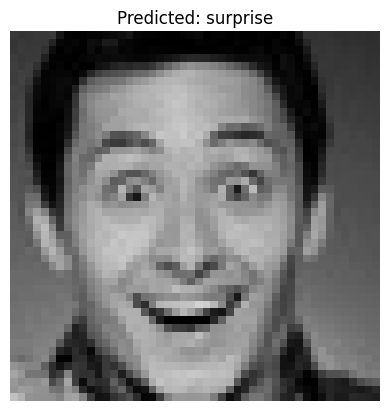

📊 Prediction Probabilities:
  Angry    : 0.0000
  Disgust  : 0.0000
  Fear     : 0.0013
  Happy    : 0.2615
  Neutral  : 0.0000
  Sad      : 0.0000
  Surprise : 0.7371


In [ ]:
# === Pick Random Image ===
all_classes = sorted(os.listdir(dataset_dir))  # Ensure order
chosen_class = random.choice(all_classes)
img_name = random.choice(os.listdir(os.path.join(dataset_dir, chosen_class)))
full_path = os.path.join(dataset_dir, chosen_class, img_name)

# === Preprocess ===
img = cv2.imread(full_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray, (48, 48)) / 255.0
reshaped = np.reshape(resized, (1, 48, 48, 1))

# === Predict ===
probs = model.predict(reshaped)[0]
predicted_label = emotion_labels[np.argmax(probs)]

# === Show Image and Prediction ===
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Predicted: {predicted_label}")
plt.show()

# === Optional: Print Probabilities ===
print("📊 Prediction Probabilities:")
for label, prob in zip(emotion_labels, probs):
    print(f"  {label.capitalize():<9}: {prob:.4f}")

facial_expression = predicted_label

## Model 6 (Text-Based Psychological Analysis)

In [ ]:
# Just download stopwords, no punkt to avoid weird issues
nltk.download('stopwords')

# Load model + vectorizer
model = joblib.load("/content/drive/MyDrive/Hackathon Models/6. Text-Based Psychological Analysis/text_model.pkl")
vectorizer = joblib.load("/content/drive/MyDrive/Hackathon Models/6. Text-Based Psychological Analysis/tfidf_vectorizer.pkl")

# Define stopwords
stop_words = set(stopwords.words("english"))

# Custom tokenizer (no punkt!)
def simple_tokenize(text):
    return re.findall(r"\b\w+\b", text)

# Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|\#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\n", " ", text)
    tokens = simple_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Prediction
def predict_psychological_state(text):
    cleaned = preprocess_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    return prediction

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Test
sample = "i can't feel the happiness anymore"
predicted_state = predict_psychological_state(sample)
print("The Entired Text is :")
print(sample)
print()
print("🧠 Predicted Mental Health Status:", predicted_state)


text_based = predicted_state

The Entired Text is :
i can't feel the happiness anymore

🧠 Predicted Mental Health Status: Depression


## Model 7. OpenAI Model

In [ ]:
#put you OpenAI API key
openai.api_key = ""

#fine-tuned model name
FINE_TUNED_MODEL = "ft:gpt-3.5-turbo-0125:personal::BGbObCVl"

def run_model_7_summary(vital_signs, sleep, bone, speech_emotion, facial_expression, text_based):
    prompt = (
        f"Model 1 (Vital Signs Monitoring): {vital_signs}\n"
        f"Model 2 (Sleep Pattern and Fatigue): {sleep}\n"
        f"Model 3 (Bone Density and Microgravity): {bone}\n"
        f"Model 4 (Speech Emotion Recognition): {speech_emotion}\n"
        f"Model 5 (Facial Expression Recognition): {facial_expression}\n"
        f"Model 6 (Text-Based Psychological Analysis): {text_based}\n"
        "Based on these results, write a short health scan summary and provide recommendations."
    )

    response = openai.chat.completions.create(
        model=FINE_TUNED_MODEL,
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0.4
    )

    return response.choices[0].message.content

print("The Inputs from The 6 Models Are:")
print()
print(f"Model 1 (Vital Signs Monitoring): {vital_signs}\n"
        f"Model 2 (Sleep Pattern and Fatigue): {sleep}\n"
        f"Model 3 (Bone Density and Microgravity): {bone}\n"
        f"Model 4 (Speech Emotion Recognition): {speech_emotion}\n"
        f"Model 5 (Facial Expression Recognition): {facial_expression}\n"
        f"Model 6 (Text-Based Psychological Analysis): {text_based}\n")

# === Run Model 7 (Final Summary) ===
final_summary = run_model_7_summary(
    vital_signs, sleep, bone, speech_emotion, facial_expression, text_based
)

print("🧾 AI Health Summary:\n")
print(final_summary)

The Inputs from The 6 Models Are:

Model 1 (Vital Signs Monitoring): High Risk
Model 2 (Sleep Pattern and Fatigue): Sleep Apnea
Model 3 (Bone Density and Microgravity): Low Risk
Model 4 (Speech Emotion Recognition): happy
Model 5 (Facial Expression Recognition): surprise
Model 6 (Text-Based Psychological Analysis): Depression

🧾 AI Health Summary:

The analysis indicates critical cardiovascular indicators and elevated vital signs.

📋 Recommendations:
📌 Schedule a medical evaluation within 24 hours.
📌 Begin remote monitoring for early intervention.
📌 Follow up with a sleep specialist for further tests.
